In [38]:
import datasets
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

from src.config import RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR

In [3]:
# embeddings
ds = datasets.load_from_disk(PROCESSED_DATA_DIR / "meanpool__intfloat__multilingual-e5-large-instruct_identify_author")
df_emb = ds.to_pandas().rename(columns={"novel": "FILENAME"})
print(len(df_emb))

839


In [4]:
# metadata
meta = pd.read_excel(RAW_DATA_DIR / "DANISH_CORPUS_METADATA_AUGUST20.xlsx")
print(len(meta))
meta.head()
df = df_emb.merge(meta, on='FILENAME', how='left')
df = df.drop_duplicates(subset=['FILENAME'])
df = df.sort_values(by="YEAR")
print(len(df))

838
839


In [5]:
year_range = df["YEAR"].unique().tolist()

windows = []
for year in year_range:
    w_min = year
    w_max = year + 2

    subset = df.loc[
        (df["YEAR"] >= w_min) & (df["YEAR"] <= w_max)
        ]
    windows.append(subset)


In [50]:
# position to relative to self in t_i-1
self_1 = []
self_2 = []
self_3 = []

for i in range(len(windows)):
    t_i = None
    t_m1 = None
    t_m2 = None
    t_m3 = None

    t_i = windows[i]
    t_i = t_i[t_i["E_CANON"] == 1]
    if len(t_i) > 0:
        t_i = np.vstack(t_i["embedding"].tolist())

        if i > 0:
            t_m1 = windows[i - 1]
            t_m1 = t_m1.query("E_CANON == 1")
            t_m1 = np.vstack(t_m1["embedding"].tolist())
        if i > 1:
            t_m2 = windows[i - 2]
            t_m2 = t_m2.query("E_CANON == 1")
            t_m2 = np.vstack(t_m2["embedding"].tolist())
        if i > 2:
            t_m3 = windows[i - 3]
            t_m3 = t_m3.query("E_CANON == 1")
            t_m3 = np.vstack(t_m3["embedding"].tolist())
        
        if t_m1 is not None:
            d_1 = pairwise_distances(t_i, t_m1, metric="cosine")
            self_1.append(d_1)
        else:
            self_1.append(0)

        if t_m2 is not None:
            d_2 = pairwise_distances(t_i, t_m2, metric="cosine")
            self_2.append(d_2)
        else:
            self_2.append(0)
        
        if t_m3 is not None:
            d_3 = pairwise_distances(t_i, t_m3, metric="cosine")
            self_3.append(d_3)
        else:
            self_3.append(0)
    
    else:
        self_1.append(0)
        self_2.append(0)
        self_3.append(0)

In [55]:
mean_self_1 = [np.mean(mat) for mat in self_1]
mean_self_2 = [np.mean(mat) for mat in self_2]
mean_self_3 = [np.mean(mat) for mat in self_3]

assert len(mean_self_1) == len(mean_self_2) == len(mean_self_3)

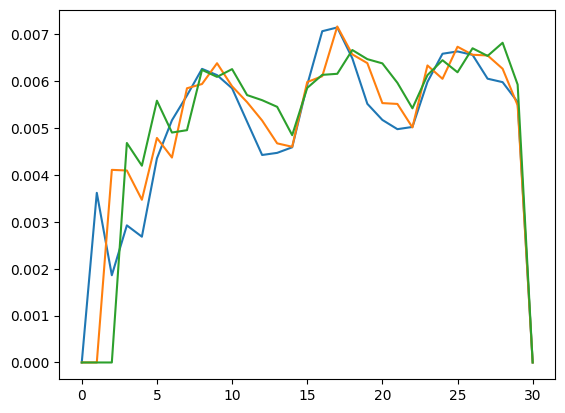

In [56]:
import matplotlib.pyplot as plt

plt.plot(mean_self_1)
plt.plot(mean_self_2)
plt.plot(mean_self_3)

In [57]:
# position relative to non-canon in t_i
inter_0 = []

for i in range(len(windows)):

    t_canon = windows[i].query("E_CANON == 1")

    if len(t_canon) > 0:
        t_canon = np.vstack(t_canon["embedding"].tolist())
    
        t_pulp = windows[i].query("E_CANON == 0")
        t_pulp = np.vstack(t_pulp["embedding"].tolist())

        d_inter = pairwise_distances(t_canon, t_pulp, metric="cosine")
        inter_0.append(d_inter)

    else:
        inter_0.append(0)

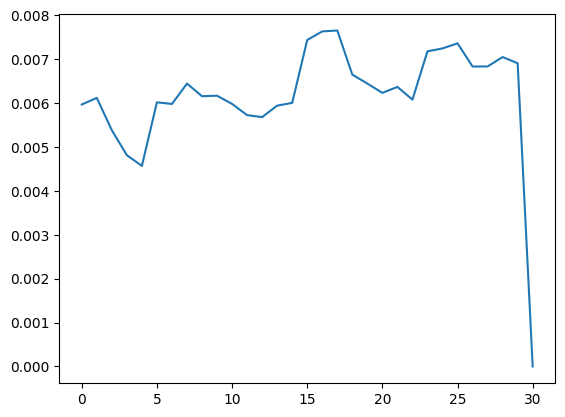

In [58]:
mean_inter_0 = [np.mean(mat) for mat in inter_0]

plt.plot(mean_inter_0)